<a href="https://colab.research.google.com/github/putraaryawinata/Prosthetics-Project/blob/master/PreprocessingKakiBionic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
# import tensorflow_addons as tfa
tf.__version__
# tfa.__version__

'2.8.2'

In [13]:
def array_to_excel(array, name_file):
  df = pd.DataFrame(array)
  df.to_excel(excel_writer = "{}.xlsx".format(name_file))

# Kalman Preprocessing

In [16]:
def kalman_filter(dataset, init_val = None, init_sd = 0.5, measure_sd = 0.1315, Q = 0.01):
  if init_val == None:
    init_val = dataset[0]
  x = init_val
  p = init_sd + Q
  m_sd = measure_sd
  
  arr_x = np.array([])
  arr_p = np.array([])
  arr_K = np.array([])

  for i in range(len(dataset)):
    K_gain = p / (p + m_sd)
    x = x + K_gain * (dataset[i] - x)
    p = ((1 - K_gain) * p) + Q

    arr_x = np.append(arr_x, x)
    arr_p = np.append(arr_p, p)
    arr_K = np.append(arr_K, K_gain)
  
  return arr_x, arr_p, arr_K

In [27]:
naik_tangga = pd.read_csv('naik_tangga22mei.csv')
sudut_naik_tangga = naik_tangga.iloc[:, 1:].values

turun_tangga = pd.read_csv('turun_tangga22mei.csv')
sudut_turun_tangga = turun_tangga.iloc[:, 1:].values

In [29]:
kalman_naik_tangga, _, _ = kalman_filter(sudut_naik_tangga, init_val = None, init_sd = 0.5, measure_sd = 0.1315, Q = 0.01)
kalman_turun_tangga, _, _ = kalman_filter(sudut_turun_tangga, init_val = None, init_sd = 0.5, measure_sd = 0.1315, Q = 0.01)

In [31]:
array_to_excel(sudut_naik_tangga, "sudut/sudut_naik_tangga_raw")
array_to_excel(sudut_turun_tangga, "sudut/sudut_turun_tangga_raw")
array_to_excel(kalman_naik_tangga, "sudut/sudut_naik_tangga_kalman")
array_to_excel(kalman_turun_tangga, "sudut/sudut_turun_tangga_kalman")

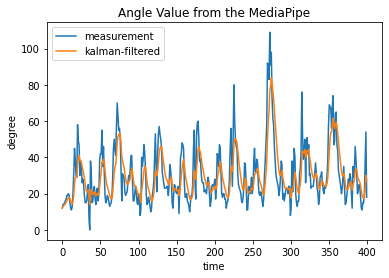

In [ ]:
plt.plot(sudut_naik_tangga[:400], label = "measurement")
plt.plot(kalman_naik_tangga[:400], label = "kalman-filtered")
plt.xlabel('time')
plt.ylabel('analog value of the sensor')
plt.title('IMU Sensor Value on X-axis')
plt.legend(loc='upper left')
plt.show()

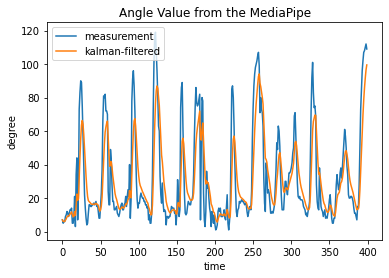

In [ ]:
plt.plot(sudut_turun_tangga[:400], label = "measurement")
plt.plot(kalman_turun_tangga[:400], label = "kalman-filtered")
plt.xlabel('time')
plt.ylabel('degree')
plt.title('Angle Value from the MediaPipe')
plt.legend(loc='upper left')
plt.show()

In [ ]:
kalman_naik_tangga.shape

(2949,)

In [ ]:
kalman_turun_tangga.shape

(2708,)

# Olah data sensor

In [1]:
import re

In [4]:
def preprocess_signal_fsr(txt_path):
  rows = []
  with open(txt_path) as f:
    lines_naik = f.readlines()
  for line in lines_naik:
    data = re.search(r"(.*) -> A0 (.*) A1 (.*) A2 (.*) A3 (.*) A4 (.*) A5 (.*) ", line)
    rows.append([data.group(1), int(data.group(2)), int(data.group(3)), int(data.group(4)), int(data.group(5)), int(data.group(6)), int(data.group(7))])
  
  return rows

In [9]:
signal_naik_tangga = np.array(preprocess_signal_fsr('test10mei22(naikTangga).txt'))
signal_naik_tangga = signal_naik_tangga[:, 1:]
signal_naik_tangga = signal_naik_tangga.astype(float)
print(signal_naik_tangga.shape)

signal_turun_tangga = np.array(preprocess_signal_fsr('test10mei22(turunTangga).txt'))
signal_turun_tangga = signal_turun_tangga[:, 1:]
signal_turun_tangga = signal_turun_tangga.astype(float)
print(signal_turun_tangga.shape)

(2903, 6)
(2671, 6)


In [14]:
array_to_excel(signal_naik_tangga, "signal_naik_tangga_raw")
array_to_excel(signal_turun_tangga, "signal_turun_tangga_raw")

In [23]:
signal_turun_tangga.shape

(2671, 6)

In [24]:
kalman_sensor_naik_tangga, _, _ = kalman_filter(signal_naik_tangga, init_val = None, init_sd = 0.5, measure_sd = 0.1315, Q = 0.01)
kalman_sensor_turun_tangga, _, _ = kalman_filter(signal_turun_tangga, init_val = None, init_sd = 0.5, measure_sd = 0.1315, Q = 0.01)

In [25]:
kalman_sensor_naik_tangga = kalman_sensor_naik_tangga.reshape(2903, 6)
kalman_sensor_turun_tangga = kalman_sensor_turun_tangga.reshape(2671, 6)

In [26]:
array_to_excel(kalman_sensor_naik_tangga, "signal_naik_tangga_kalman")
array_to_excel(kalman_sensor_turun_tangga, "signal_turun_tangga_kalman")

In [ ]:
kalman_sensor_naik_tangga[:400, 0]

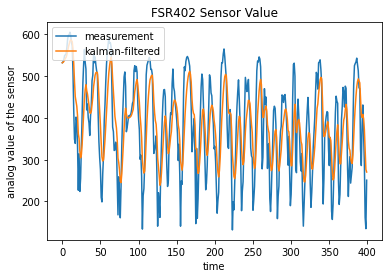

In [ ]:
plt.plot(signal_naik_tangga[:400, 5], label = "measurement")
plt.plot(kalman_sensor_naik_tangga[:400, 5], label = "kalman-filtered")
plt.xlabel('time')
plt.ylabel('analog value of the sensor')
plt.title('FSR402 Sensor Value')
plt.legend(loc='upper left')
plt.show()

# Combine Data Kalman dengan Sensor 

In [ ]:
# Data Sudut
kalman_naik_tangga = kalman_naik_tangga[:len(signal_naik_tangga)]
y_train = kalman_naik_tangga[:2323]
y_valid = kalman_naik_tangga[2323: 2613]
y_test = kalman_naik_tangga[2613:]

kalman_turun_tangga = kalman_turun_tangga[:len(signal_turun_tangga)]
y_train = np.append(y_train, kalman_turun_tangga[:2137], axis=0)
y_valid = np.append(y_valid, kalman_turun_tangga[2137: 2404], axis=0)
y_test = np.append(y_test, kalman_turun_tangga[2404:], axis=0)

# Data Signal
x_train = signal_naik_tangga[:2323]
x_valid = signal_naik_tangga[2323: 2613]
x_test = signal_naik_tangga[2613:]

x_train = np.append(x_train, signal_turun_tangga[:2137], axis=0)
x_valid = np.append(x_valid, signal_turun_tangga[2137: 2404], axis=0)
x_test = np.append(x_test, signal_turun_tangga[2404:], axis=0)

In [ ]:
x_test[:2]

array([[111., 225., 167.,   2., 219., 335.],
       [131., 289., 258.,   2., 242., 342.]])

In [ ]:
x_test[2:4]

array([[ 63., 324., 326.,   2., 268., 331.],
       [ 52., 349., 461.,   3., 344., 344.]])

In [ ]:
for i in range(4):
  print(i)

0
1
2
3


In [ ]:
def windowed_dataset(dataset, num_window):
  num_axis = len(dataset.shape)
  windowed_ds = np.expand_dims(dataset[:num_window], axis=0)
  for i in range(len(dataset) - num_window):
    windowed_ds = np.append(windowed_ds, np.expand_dims(dataset[i+1:i+1+num_window], axis=0), axis=0)
  
  return windowed_ds

In [ ]:
len(x_train.shape ) 

3

In [ ]:
test = np.expand_dims(x_train[:10], axis=0)
test.shape

(1, 10, 6)

In [ ]:
print(windowed_dataset(x_train[:10], 10))

[[[286. 541. 611. 176. 445. 532.]
  [288. 547. 617. 194. 450. 534.]
  [292. 551. 620. 199. 456. 539.]
  [306. 554. 625. 204. 467. 549.]
  [302. 552. 629. 194. 472. 551.]
  [305. 549. 632. 200. 473. 553.]
  [304. 555. 644. 229. 478. 568.]
  [314. 604. 649. 221. 509. 589.]
  [330. 630. 650. 220. 530. 598.]
  [336. 642. 654. 219. 537. 599.]]]


In [ ]:
x_train[:10]

array([[286., 541., 611., 176., 445., 532.],
       [288., 547., 617., 194., 450., 534.],
       [292., 551., 620., 199., 456., 539.],
       [306., 554., 625., 204., 467., 549.],
       [302., 552., 629., 194., 472., 551.],
       [305., 549., 632., 200., 473., 553.],
       [304., 555., 644., 229., 478., 568.],
       [314., 604., 649., 221., 509., 589.],
       [330., 630., 650., 220., 530., 598.],
       [336., 642., 654., 219., 537., 599.]])

In [ ]:
windowed_x_train = windowed_dataset(x_train, 50)
windowed_x_valid = windowed_dataset(x_valid, 50)
windowed_x_test = windowed_dataset(x_test, 50)

In [ ]:
print("windowed_x_train: {}".format(windowed_x_train.shape))
print("windowed_x_valid: {}".format(windowed_x_valid.shape))
print("windowed_x_test: {}".format(windowed_x_test.shape))

windowed_x_train: (4411, 50, 6)
windowed_x_valid: (508, 50, 6)
windowed_x_test: (508, 50, 6)




```
x_train: (4460, 6)
x_valid: (557, 6)
x_test: (557, 6)
```



In [ ]:
windowed_y_train = windowed_dataset(y_train, 50)
windowed_y_valid = windowed_dataset(y_valid, 50)
windowed_y_test = windowed_dataset(y_test, 50)

In [ ]:
print("windowed_y_train: {}".format(windowed_y_train.shape))
print("windowed_y_valid: {}".format(windowed_y_valid.shape))
print("windowed_y_test: {}".format(windowed_y_test.shape))

windowed_y_train: (4411, 50)
windowed_y_valid: (508, 50)
windowed_y_test: (508, 50)




```
y_train: (4460,)
y_valid: (557,)
y_test: (557,)
```



# ANN

In [ ]:
# !pip install tensorflow-addons

In [ ]:
def model_ann(x_train, x_valid, y_train, y_valid):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1),
  ])

  model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9),
                loss = 'mae',
                metrics = ['mae'])

  model.fit(x_train, y_train, epochs = 100, validation_data = (x_valid, y_valid), verbose = 1)

  model.summary()

  return model

In [ ]:
print('RMSprop')
model_ann = model_ann(windowed_x_train, windowed_x_valid, windowed_y_train, windowed_y_valid)

RMSprop
Epoch 1/100
138/138 [==============================] - 3s 14ms/step - loss: 17.6865 - mae: 17.6865 - val_loss: 16.9517 - val_mae: 16.9517
Epoch 2/100
138/138 [==============================] - 2s 11ms/step - loss: 13.9453 - mae: 13.9453 - val_loss: 16.8344 - val_mae: 16.8344
Epoch 3/100
138/138 [==============================] - 2s 11ms/step - loss: 13.5582 - mae: 13.5582 - val_loss: 17.8259 - val_mae: 17.8259
Epoch 4/100
138/138 [==============================] - 2s 12ms/step - loss: 13.1510 - mae: 13.1510 - val_loss: 17.3168 - val_mae: 17.3168
Epoch 5/100
138/138 [==============================] - 2s 11ms/step - loss: 12.8139 - mae: 12.8139 - val_loss: 17.7258 - val_mae: 17.7258
Epoch 6/100
138/138 [==============================] - 2s 11ms/step - loss: 12.5783 - mae: 12.5783 - val_loss: 17.5176 - val_mae: 17.5176
Epoch 7/100
138/138 [==============================] - 2s 11ms/step - loss: 12.3117 - mae: 12.3117 - val_loss: 17.3065 - val_mae: 17.3065
Epoch 8/100
138/138 [=====

In [ ]:
check_y_pred_ann = model_ann.predict(windowed_x_train)
check_y_pred_ann = check_y_pred_ann.reshape(4411, 50)

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(windowed_y_train, check_y_pred_ann))

0.6873694437995141


# RNN (use LSTM)

In [ ]:
x_train_rnn = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_valid_rnn = x_valid.reshape(x_valid.shape[0], 1, x_valid.shape[1])
x_test_rnn = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [ ]:
windowed_y_train_rnn = windowed_y_train[:, 49]
windowed_y_valid_rnn = windowed_y_valid[:, 49]
windowed_y_test_rnn = windowed_y_test[:, 49]

In [ ]:
def model_rnn(x_train, x_valid, y_train, y_valid):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5, momentum=0.9),
                loss = 'mae',
                metrics = ['mae'])
  model.fit(x_train, y_train, epochs = 20, validation_data = (x_valid, y_valid), verbose = 1)
  model.summary()
  return model

In [ ]:
model_rnn_1 = model_rnn(windowed_x_train, windowed_x_valid, windowed_y_train_rnn, windowed_y_valid_rnn)

Epoch 1/20
138/138 [==============================] - 108s 691ms/step - loss: 25.1480 - mae: 25.1480 - val_loss: 21.1853 - val_mae: 21.1853
Epoch 2/20
138/138 [==============================] - 93s 674ms/step - loss: 16.2440 - mae: 16.2440 - val_loss: 15.5344 - val_mae: 15.5344
Epoch 3/20
138/138 [==============================] - 91s 661ms/step - loss: 15.6581 - mae: 15.6581 - val_loss: 15.6047 - val_mae: 15.6047
Epoch 4/20
138/138 [==============================] - 91s 663ms/step - loss: 15.4559 - mae: 15.4559 - val_loss: 15.5899 - val_mae: 15.5899
Epoch 5/20
138/138 [==============================] - 92s 667ms/step - loss: 15.3199 - mae: 15.3200 - val_loss: 15.4794 - val_mae: 15.4794
Epoch 6/20
138/138 [==============================] - 92s 670ms/step - loss: 15.2178 - mae: 15.2178 - val_loss: 15.2883 - val_mae: 15.2883
Epoch 7/20
138/138 [==============================] - 93s 671ms/step - loss: 15.1548 - mae: 15.1548 - val_loss: 15.4024 - val_mae: 15.4024
Epoch 8/20
138/138 [======

In [ ]:
print('RMSprop')
model_rnn = model_rnn(windowed_x_train, windowed_x_valid, windowed_y_train, windowed_y_valid)

RMSprop
Epoch 1/20
138/138 [==============================] - 105s 676ms/step - loss: 21.7637 - mae: 21.7637 - val_loss: 15.5001 - val_mae: 15.5001
Epoch 2/20
138/138 [==============================] - 89s 644ms/step - loss: 15.0846 - mae: 15.0846 - val_loss: 15.1974 - val_mae: 15.1974
Epoch 3/20
138/138 [==============================] - 89s 647ms/step - loss: 14.7522 - mae: 14.7522 - val_loss: 14.9975 - val_mae: 14.9975
Epoch 4/20
138/138 [==============================] - 89s 647ms/step - loss: 13.0970 - mae: 13.0970 - val_loss: 14.4029 - val_mae: 14.4029
Epoch 5/20
138/138 [==============================] - 89s 645ms/step - loss: 10.0079 - mae: 10.0079 - val_loss: 15.1207 - val_mae: 15.1207
Epoch 6/20
138/138 [==============================] - 90s 651ms/step - loss: 7.7086 - mae: 7.7086 - val_loss: 15.7947 - val_mae: 15.7947
Epoch 7/20
138/138 [==============================] - 89s 648ms/step - loss: 6.8291 - mae: 6.8291 - val_loss: 15.5495 - val_mae: 15.5495
Epoch 8/20
138/138 [==

In [ ]:
check_y_pred = model_rnn.predict(windowed_x_train)
check_y_pred_1 = model_rnn_1.predict(windowed_x_valid)

In [ ]:
check_y_pred.shape

(4411, 50, 1)

In [ ]:
windowed_y_valid_rnn

In [ ]:
check_y_pred = check_y_pred.reshape(4411, 50)
#check_y_pred_1 = check_y_pred_1.reshape(508, 50)

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(windowed_y_train, check_y_pred))
#print(r2_score(windowed_y_valid_rnn, check_y_pred_1))

0.9687859959448734


In [ ]:
model_rnn.evaluate(x_test_rnn, y_test)

18/18 [==============================] - 0s 11ms/step - loss: 20.0816 - mae: 20.0816


[20.08162498474121, 20.08162498474121]

In [ ]:
y_test.shape

(557,)

In [ ]:
y_pred_valid = model_rnn.predict(x_valid_rnn)
y_pred_test = model_rnn.predict(x_test_rnn)

In [ ]:
y_pred_valid = y_pred_valid.reshape(557,)
y_pred_test = y_pred_test.reshape(557,)

In [ ]:
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_valid, y_pred_valid)
result = metric.result()
result.numpy()

-0.2924316

In [ ]:
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_test, y_pred_test)
result = metric.result()
result.numpy()

-0.2831465

# SVR

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

xs = sc_x.fit_transform(x_train)
y_train_svr = y_train.reshape(-1, 1)
ys = sc_y.fit_transform(y_train_svr)

In [ ]:
from sklearn.svm import SVR
bionicleg_svr = SVR(kernel = 'rbf')
bionicleg_svr.fit(xs, ys)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [ ]:
bionicleg_svr.score(x_valid, y_valid)

-3.209343797902589